<a href="https://colab.research.google.com/github/Muqeem01/Jraph/blob/main/JraphNewDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/deepmind/jraph.git
!pip install flax
!pip install dm-haiku

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html > /dev/null
!pip install torch-geometric > /dev/null

# !pip install --upgrade pip > /dev/null
# Installs the wheel compatible with CUDA 11 and cuDNN 8.2 or newer.
!pip install "jax[cpu]" -f https://storage.googleapis.com/jax-releases/jax_releases.html  > /dev/null
!pip install jraph > /dev/null
!pip install flax > /dev/null

  Cloning https://github.com/deepmind/jraph.git to /tmp/pip-req-build-ta628nch
  Running command git clone --filter=blob:none --quiet https://github.com/deepmind/jraph.git /tmp/pip-req-build-ta628nch
  Resolved https://github.com/deepmind/jraph.git to commit 51f5990104f7374492f8f3ea1cbc47feb411c69c
  Preparing metadata (setup.py) ... done
  Created wheel for jraph: filename=jraph-0.0.6.dev0-py3-none-any.whl size=91245 sha256=bdf2b2c2de787d781b4417faa1e380dc24fdb7512a991bdf64742f081d026975
  Stored in directory: /tmp/pip-ephem-wheel-cache-yr_fhag2/wheels/76/61/34/8fb9aa4dac00d471de4a5f7157614181de683c445fc2d640db
Successfully built jraph
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.0/371.0 kB 7.9 MB/s eta 0:00:00


In [3]:
# Imports
%matplotlib inline
import functools
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import jax.tree_util as tree
import jraph
import flax
import haiku as hk
import optax
import pickle
import numpy as onp
import networkx as nx
from typing import Any, Callable, Dict, List, Optional, Tuple

# Imports

import functools
import jax
import jax.numpy as jnp
import time
import jraph
import flax
import optax
import pickle
import numpy as np
import torch

from torch_geometric.data import Data, Dataset
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

from flax import linen as nn
from flax.training import train_state
import pathlib
import csv
import time
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
dataset = TUDataset(root='/tmp/ENZYMES', name='ENZYMES')

Processing...
Done!


In [5]:
# Assuming dataset is already initialized
num_classes = dataset.num_classes
print("Number of classes:", num_classes)


Number of classes: 6


In [7]:
import torch
from torch.utils.data import Dataset
class ToyDataset(Dataset):
    def __init__(self, dataset):
      """ Initializes the data reader by loading in data. """
      self.dataset = dataset

    def __len__(self):
      return len(self.dataset)

    def __getitem__(self, idx):
      sample = self.dataset[idx]

      data = Data(node_attr = sample.x,
                  num_nodes = sample.num_nodes,
                  n_node = sample.num_nodes,
                  n_edge = sample.num_edges,
                  senders = sample.edge_index[0],
                  receivers = sample.edge_index[1],
                  y = sample.y,
                  globals=torch.ones([sample.num_nodes, 1])
                  )

      return data

In [8]:
train_dataset_ = dataset[:540]
test_dataset_ = dataset[540:]

train_dataset = ToyDataset(train_dataset_)
test_dataset = ToyDataset(test_dataset_)

print(f'Number of training graphs: {len(train_dataset_)}')
print(f'Number of test graphs: {len(test_dataset_)}')

Number of training graphs: 540
Number of test graphs: 60


In [9]:
train_reader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_reader = DataLoader(test_dataset, batch_size=64, shuffle=False)

for step, data in enumerate(train_reader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(y=[64], node_attr=[2070, 3], num_nodes=2070, n_node=[64], n_edge=[64], senders=[7940], receivers=[7940], globals=[2070, 1], batch=[2070], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(y=[64], node_attr=[2068, 3], num_nodes=2068, n_node=[64], n_edge=[64], senders=[8002], receivers=[8002], globals=[2068, 1], batch=[2068], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(y=[64], node_attr=[2123, 3], num_nodes=2123, n_node=[64], n_edge=[64], senders=[7862], receivers=[7862], globals=[2123, 1], batch=[2123], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(y=[64], node_attr=[1945, 3], num_nodes=1945, n_node=[64], n_edge=[64], senders=[7546], receivers=[7546], globals=[1945, 1], batch=[1945], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(y=[64], node_attr=[2009, 3], num_nodes=2009, n_node=[64], n_edge=[64], senders=[7826], receivers=[7826],

In [75]:
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
def _nearest_bigger_power_of_two(x: int) -> int:
    """Computes the nearest power of two greater than x for padding."""
    y = 2
    while y < x:
        y *= 2
    return y

def pad_graph_to_nearest_power_of_two(graphs_tuple: jraph.GraphsTuple) -> jraph.GraphsTuple:
    """Pads a batched `GraphsTuple` to the nearest power of two.

    For example, if a `GraphsTuple` has 7 nodes, 5 edges and 3 graphs, this method
    would pad the `GraphsTuple` nodes and edges:
        7batch_sizedes --> 8 nodes (2^3)
        5 edges --> 8 edges (2^3)

    And since padding is accomplished using `jraph.pad_with_graphs`, an extra
    graph and node is added:
        8 nodes --> 9 nodes
        3 graphs --> 4 graphs

    Args:
        graphs_tuple: a batched `GraphsTuple` (can be batch size 1).

    Returns:
        A graphs_tuple batched to the nearest power of two.
    """
    # Add 1 since we need at least one padding node for pad_with_graphs.
    pad_nodes_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_node)) + 1
    pad_edges_to = _nearest_bigger_power_of_two(jnp.sum(graphs_tuple.n_edge))
    # Add 1 since we need at least one padding graph for pad_with_graphs.
    # We do not pad to nearest power of two because the batch size is fixed.
    pad_graphs_to = graphs_tuple.n_node.shape[0] + 1
    return jraph.pad_with_graphs(graphs_tuple, pad_nodes_to, pad_edges_to,
                               pad_graphs_to)


def get_batched_padded_graph_tuples(batch):
    graphs = jraph.GraphsTuple(
            nodes=np.array(batch.node_attr),
            edges=np.array(batch.n_edge), # this particular data doesn't have edge features, hence we set to None
            n_node=np.array(batch.n_node),
            n_edge=np.array(batch.n_edge),
            senders=np.array(batch.senders),
            receivers=np.array(batch.receivers),
            globals=np.array(batch.globals))

    labels = np.array(batch.y)
    graphs = pad_graph_to_nearest_power_of_two(graphs) # padd the whole batch once
    return graphs, labels

In [76]:
%%time
batch = next(iter(train_reader))
graphs, labels = get_batched_padded_graph_tuples(batch)


CPU times: user 25.8 ms, sys: 0 ns, total: 25.8 ms
Wall time: 27.6 ms


In [82]:
train_reader=get_batched_padded_graph_tuples(batch)

In [17]:
def convert_jraph_to_networkx_graph(jraph_graph: jraph.GraphsTuple) -> nx.Graph:
  nodes, edges, receivers, senders, _, _, _ = jraph_graph
  nx_graph = nx.DiGraph()
  if nodes is None:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n)
  else:
    for n in range(jraph_graph.n_node[0]):
      nx_graph.add_node(n, node_feature=nodes[n])
  if edges is None:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(int(senders[e]), int(receivers[e]))
  else:
    for e in range(jraph_graph.n_edge[0]):
      nx_graph.add_edge(
          int(senders[e]), int(receivers[e]), edge_feature=edges[e])
  return nx_graph


def draw_jraph_graph_structure(jraph_graph: jraph.GraphsTuple) -> None:
  nx_graph = convert_jraph_to_networkx_graph(jraph_graph)
  pos = nx.spring_layout(nx_graph)
  nx.draw(
      nx_graph, pos=pos, with_labels=True, node_size=500, font_color='yellow')

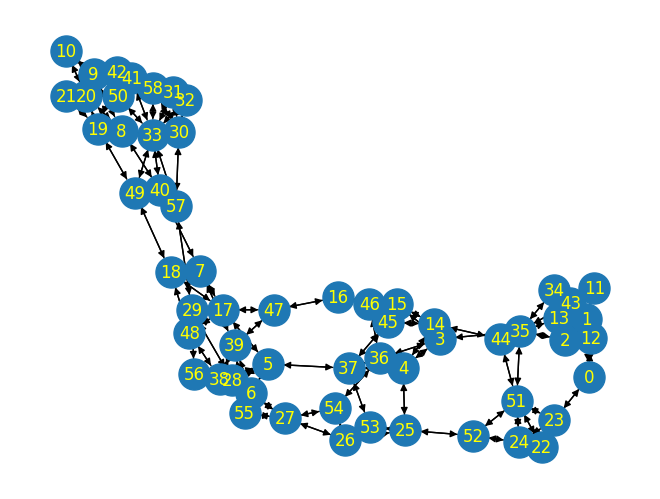

In [18]:
draw_jraph_graph_structure(graphs)

In [55]:
import torch_geometric.data as tg_data
from jraph._src.models import GraphMapFeatures
# Adapted from https://github.com/deepmind/jraph/blob/master/jraph/ogb_examples/train.py
from torch_geometric.data.storage import GlobalStorage
@jraph.concatenated_args
def edge_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Edge update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def node_update_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Node update function for graph net."""
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(128)])
  return net(feats)

@jraph.concatenated_args
def update_global_fn(feats: jnp.ndarray) -> jnp.ndarray:
  """Global update function for graph net."""
  # MUTAG is a binary classification task, so output pos neg logits.
  net = hk.Sequential(
      [hk.Linear(128), jax.nn.relu,
       hk.Linear(2)])
  return net(feats)

def net_fn(graph: jraph.GraphsTuple) -> jraph.GraphsTuple:
  # # Add a global paramater for graph classification.

  graph = graph._replace(globals=jnp.zeros([graph.n_node.shape[0], 1]))

  embedder = jraph.GraphMapFeatures(
       hk.Linear(128),
       hk.Linear(128),
       hk.Linear(128))

  net = jraph.GraphNetwork(
      update_node_fn=node_update_fn,
      update_edge_fn=edge_update_fn,
      update_global_fn=update_global_fn)
  embedder = GraphMapFeatures(graph)
  return net(embedder(graph))

In [56]:
import jax
import jax.numpy as jnp
import haiku as hk
import jraph
from typing import Tuple
from typing import List
def compute_loss(params: hk.Params, graph: jraph.GraphsTuple, label: jnp.ndarray,
                 net: jraph.GraphsTuple) -> Tuple[jnp.ndarray, jnp.ndarray]:
  """Computes loss and accuracy."""
  pred_graph = net.apply(params, graph)
  preds = jax.nn.log_softmax(pred_graph.globals)
  targets = jax.nn.one_hot(label, 2)

  # Since we have an extra 'dummy' graph in our batch due to padding, we want
  # to mask out any loss associated with the dummy graph.
  # Since we padded with `pad_with_graphs` we can recover the mask by using
  # get_graph_padding_mask.
  mask = jraph.get_graph_padding_mask(pred_graph)

  # Cross entropy loss.
  loss = -jnp.mean(preds * targets * mask[:, None])

  # Accuracy taking into account the mask.
  accuracy = jnp.sum(
      (jnp.argmax(pred_graph.globals, axis=1) == label) * mask) / jnp.sum(mask)
  return loss, accuracy

In [57]:
from typing import Dict
from typing import Any
from torch_geometric.data.storage import GlobalStorage
def train(train_reader, num_train_steps: int) -> hk.Params:
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    """Training loop."""

    # Transform impure `net_fn` to pure functions with hk.transform.
    net = hk.without_apply_rng(hk.transform(net_fn))
    # Get a candidate graph and label to initialize the network.
    batch = next(iter(train_reader))
    graph = batch

    # Initialize the network.
    params = net.init(jax.random.PRNGKey(42), graph)
    # Initialize the optimizer.
    opt_init, opt_update = optax.adam(1e-4)
    opt_state = opt_init(params)

    compute_loss_fn = functools.partial(compute_loss, net=net)
    # We jit the computation of our loss, since this is the main computation.
    # Using jax.jit means that we will use a single accelerator. If you want
    # to use more than 1 accelerator, use jax.pmap. More information can be
    # found in the jax documentation.
    compute_loss_fn = jax.jit(jax.value_and_grad(compute_loss_fn, has_aux=True))
    for idx, batch in enumerate(train_reader):

    # Convert batch to padded GraphsTuple

     graphs, labels = get_batched_padded_graph_tuples(batch)

        # Jax will re-jit your graphnet every time a new graph shape is encountered.
        # In the limit, this means a new compilation every training step, which
        # will result in *extremely* slow training. To prevent this, pad each
        # batch of graphs to the nearest power of two. Since jax maintains a cache
        # of compiled programs, the compilation cost is amortized.


        # Since padding is implemented with pad_with_graphs, an extra graph has
        # been added to the batch, which means there should be an extra label.
    label = jnp.concatenate([label, jnp.array([0])])

    (loss, acc), grad = compute_loss_fn(params, graph, label)
    updates, opt_state = opt_update(grad, opt_state, params)
    params = optax.apply_updates(params, updates)
    if idx % 50 == 0:
            print(f'step: {idx}, loss: {loss}, acc: {acc}')
    print('Training finished')
    return params

In [62]:
graphs.n_node.shape

(65,)

In [63]:
train(train_reader,num_train_steps=50)

AttributeError: 'GlobalStorage' object has no attribute '_replace'